In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
cd /content/drive/MyDrive/CIS5810/Final_Project/

/content/drive/MyDrive/CIS5810/Final_Project


In [34]:
%matplotlib inline


# Neural Transfer Using PyTorch


**Author**: [Alexis Jacq](https://alexis-jacq.github.io)
 
**Edited by**: [Winston Herring](https://github.com/winston6)

## Introduction

This tutorial explains how to implement the [Neural-Style algorithm](https://arxiv.org/abs/1508.06576)_
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input 
to resemble the content of the content-image and the artistic style of the style-image.

 
.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1


## Underlying Principle

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

## Importing Packages and Selecting a Device
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [ ]:
# FOR TPU ONLY
# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl

In [35]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autocast
from torch.cuda.amp import GradScaler

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models


import copy
import time

## FOR TPU ONLY
# import torch_xla
# import torch_xla.core.xla_model as xm

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## FOR TPU ONLY
# device = xm.xla_device()

## Loading the Images

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable to sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    [picasso.jpg](https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg)_ and
    [dancing.jpg](https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg)_.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.



In [44]:
# desired size of the output image
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, 2*imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    print(type(image))
    print(image.size)
    image = loader(image).unsqueeze(0)
    print(type(image))
    print(image.shape)
    return image.to(device, torch.float)


style_img = image_loader("dataset/got.jpg")
content_img = image_loader("dataset/larry.jpg")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(256, 256)
<class 'torch.Tensor'>
torch.Size([1, 3, 128, 256])
<class 'PIL.Jpeg2KImagePlugin.Jpeg2KImageFile'>
(1024, 1024)
<class 'torch.Tensor'>
torch.Size([1, 3, 128, 256])


Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



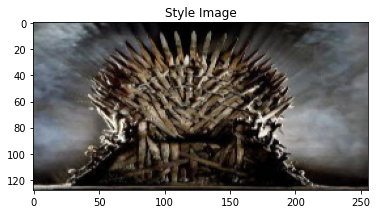

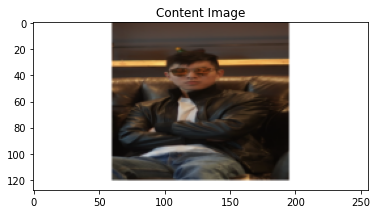

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
### Overarching loss function
loss_functions = {'mse': F.mse_loss,
                  'l1': F.l1_loss,
                  'smoothl1': F.smooth_l1_loss,
                  'huber': F.huber_loss}
top_level_loss = 'l1'

## Loss Functions
Content Loss
~~~~~~~~~~~~

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.




In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,loss_function):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
        self.loss_function = loss_functions[loss_function]

    def forward(self, input):
        self.loss = self.loss_function(input, self.target)
        return input

.. Note::
   **Important detail**: although this module is named ``ContentLoss``, it
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss function, you have to create a PyTorch autograd function 
   to recompute/implement the gradient manually in the ``backward``
   method.



### Style Loss

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.




In [ ]:
def remove_inf_nan(x):
    x[x!=x]=0
    x[~torch.isfinite(x)]=0
    return x

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return remove_inf_nan(G.div(a * b * c * d))

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature, loss_function):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss_function = loss_functions[loss_function]

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = self.loss_function(G, self.target)
        return input

## Importing the Model

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
alexnet = models.alexnet(pretrained=True).features.to(device).eval()
print(alexnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
resnet = models.resnet18(pretrained=True).eval()
modules=list(resnet.children())[:-1]
resnet=nn.Sequential(*modules)
print(resnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
my_models = {'vgg': cnn,
             'alexnet': alexnet,
             'resnet': resnet}

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [ ]:
# desired depth layers to compute style/content losses :

# THIS IS FOR VGG
# content_layers_default = ['conv_4']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# content_layers_default = ['conv_15']
# style_layers_default = ['conv_1', 'conv_5', 'conv_9', 'conv_15', 'conv_16']



# THIS IS FOR ALEXNET
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# THIS IS FOR RESNET
# content_layers_default = ['sequential_3']
# style_layers_default = ['conv_1', 'sequential_1', 'sequential_2', 'sequential_3', 'sequential_4']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               loss_function,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    j = 0  # increment every time we see a sequential
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Sequential):
            j += 1
            name = 'sequential_{}'.format(j)
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            name = 'adaptive_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, loss_function)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, loss_function)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model.to(device), style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




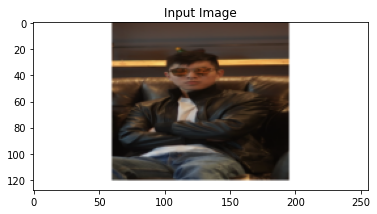

In [ ]:
input_img1 = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img2 = torch.randn(content_img.data.size(), device=device)
input_img = (7 * input_img1 + 0 * input_img2) / 7

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## Gradient Descent

As Leon Gatys, the author of the algorithm, suggested [here](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)_, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [ ]:
from functools import partial
optimizers = {'LBFGS': optim.LBFGS,
              'Adam': partial(optim.Adam, lr=1e-4, eps=1e-4),
              'SGD': partial(optim.SGD, lr=1e-2, momentum=0.3)}

In [ ]:
def get_input_optimizer(input_img, optimizer):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optimizers[optimizer]([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [ ]:
def run_style_transfer(model, normalization_mean, normalization_std,
                       content_img, style_img, input_img, 
                       loss_function = 'mse', optimizer = 'LBFGS',
                       num_steps=300,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model... (no amp)')
    print('model: ', model, 
           ', loss: ', loss_function, 
           ', optimizer: ', optimizer)
    model, style_losses, content_losses = get_style_model_and_losses(my_models[model],
        normalization_mean, normalization_std, style_img, content_img, loss_function)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    output_img = input_img.clone().detach()

    output_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(output_img, optimizer)

    print('Optimizing..')
    run = [0]
    outer_style_score = 0
    outer_content_score = 0
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                output_img.clamp_(0, 1)

            optimizer.zero_grad()

            model(output_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            nonlocal outer_style_score, outer_content_score
            outer_style_score = style_score
            outer_content_score = content_score
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        
        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        output_img.clamp_(0, 1)

    return output_img, outer_style_score.item(), outer_content_score.item()

In [ ]:
def run_style_transfer_amp(model, normalization_mean, normalization_std,
                       content_img, style_img, input_img, 
                       loss_function = 'mse', optimizer = 'Adam',
                       num_steps=300,
                       style_weight=100000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model... (with AMP)')
    print('model: ', model, 
           ', loss: ', loss_function, 
           ', optimizer: ', optimizer)
    model, style_losses, content_losses = get_style_model_and_losses(my_models[model],
        normalization_mean, normalization_std, style_img, content_img, loss_function)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    output_img = input_img.clone().detach()

    output_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(output_img, optimizer)

    scaler = GradScaler()

    print('Optimizing..')
    run = [0]
    outer_style_score = 0
    outer_content_score = 0
    while run[0] <= num_steps:
      with torch.no_grad():
        output_img.clamp_(0, 1)

      optimizer.zero_grad(set_to_none=True)

      # Runs the forward pass with autocasting.
      with autocast(device_type='cuda', dtype=torch.float16):
          model(output_img)
          
          style_score = 0
          content_score = 0

          for sl in style_losses:
              style_score += sl.loss
          for cl in content_losses:
              content_score += cl.loss
          style_score *= style_weight
          content_score *= content_weight

          outer_style_score = style_score
          outer_content_score = content_score

          loss = style_score + content_score

      # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
      # Backward passes under autocast are not recommended.
      # Backward ops run in the same dtype autocast chose for corresponding forward ops.
      scaler.scale(loss).backward()

      # # Unscales the gradients of optimizer's assigned params in-place
      # scaler.unscale_(optimizer)

      # # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
      # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=True)

      # scaler.step() first unscales the gradients of the optimizer's assigned params.
      # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
      # otherwise, optimizer.step() is skipped.
      scaler.step(optimizer)

      # Updates the scale for next iteration.
      scaler.update()

      run[0] += 1
      if run[0] % 50 == 0:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              outer_style_score.item(), outer_content_score.item()))
          print()

    # a last correction...
    with torch.no_grad():
      output_img.clamp_(0, 1)

    return output_img, outer_style_score.item(), outer_content_score.item()

Finally, we can run the algorithm.




In [ ]:
start_time = time.time()
output, _, _ = run_style_transfer_amp('vgg', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'mse', 'Adam', num_steps=2000)
end_time = time.time()
plt.figure(figsize=(20, 20))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
print('total time: ', (end_time - start_time), ' seconds')

Building the style transfer model... (with AMP)
model:  vgg , loss:  mse , optimizer:  Adam


<ipython-input-20-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-20-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..


KeyboardInterrupt: ignored

In [ ]:
start_time = time.time()
output, _, _ = run_style_transfer_amp('vgg', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'mse', 'SGD', num_steps=500)
end_time = time.time()
plt.figure(figsize=(20, 20))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
print('total time: ', (end_time - start_time), ' seconds')

Building the style transfer model... (no amp)
model:  vgg , loss:  l1 , optimizer:  LBFGS
Optimizing..


<ipython-input-178-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-178-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 15214.112305 Content Loss: 1.707015

run [100]:
Style Loss : 10729.247070 Content Loss: 1.904219

run [150]:
Style Loss : 8152.664551 Content Loss: 2.017909

run [200]:
Style Loss : 6491.723145 Content Loss: 2.088599

run [250]:
Style Loss : 5146.488770 Content Loss: 2.140859

run [300]:
Style Loss : 7713.454102 Content Loss: 2.197590

run [350]:
Style Loss : 3500.958984 Content Loss: 2.205675

run [400]:
Style Loss : 2984.276855 Content Loss: 2.227400

run [450]:
Style Loss : 6344.348633 Content Loss: 2.325004

run [500]:
Style Loss : 2144.062500 Content Loss: 2.265079

run [550]:
Style Loss : 1680.385376 Content Loss: 2.263698

run [600]:
Style Loss : 1451.620605 Content Loss: 2.262556

run [650]:
Style Loss : 1329.676392 Content Loss: 2.262362

run [700]:
Style Loss : 1236.984253 Content Loss: 2.262717

run [750]:
Style Loss : 1472.032349 Content Loss: 2.266801

run [800]:
Style Loss : 1050.299072 Content Loss: 2.266442

run [850]:
Style Loss : 972.834045 Cont

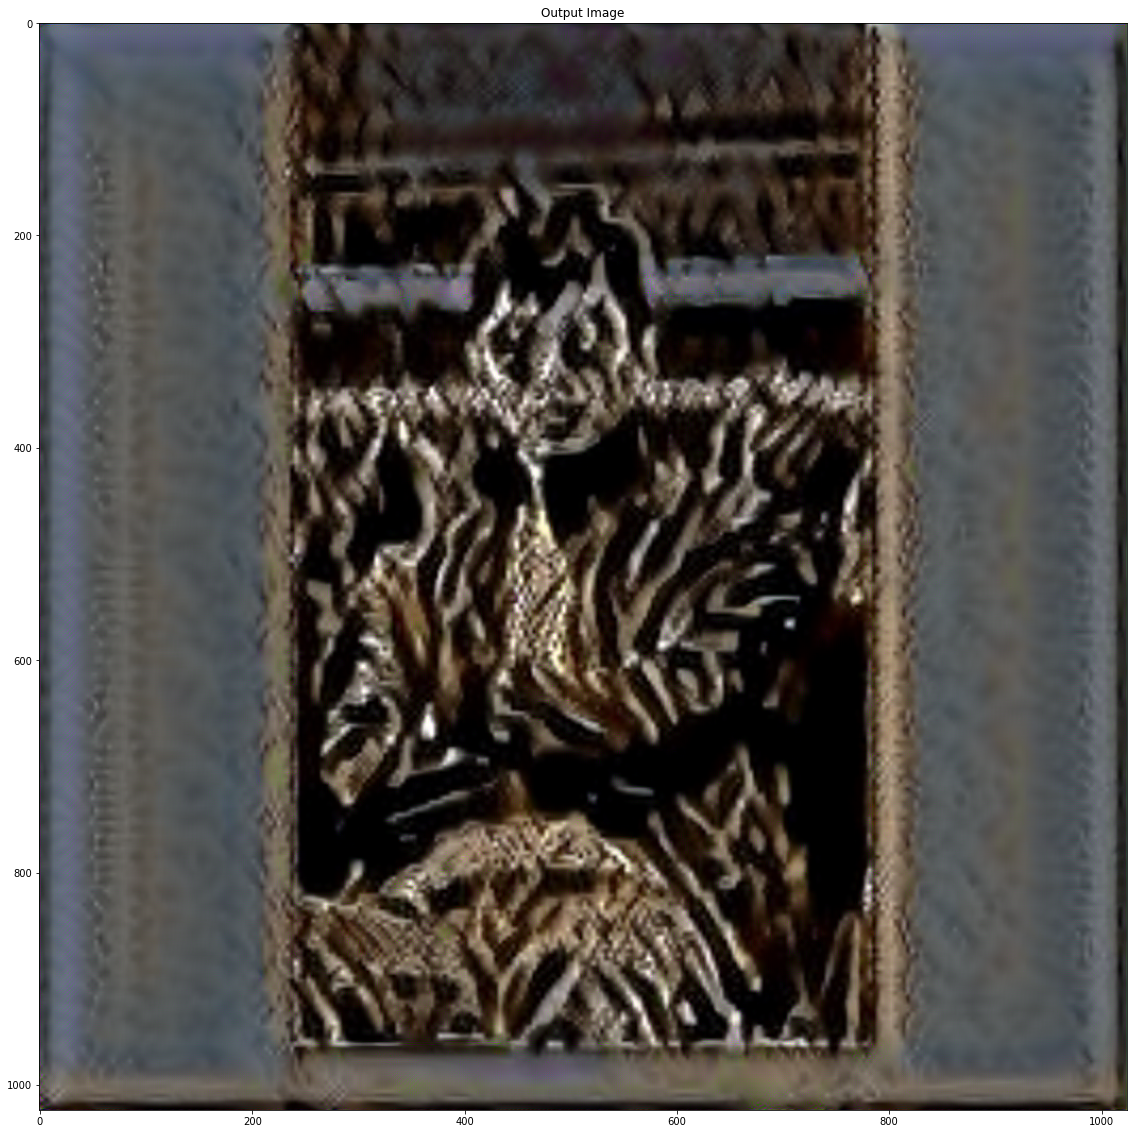

total time:  249.66815662384033  seconds


In [ ]:
start_time = time.time()
output, image, result = run_style_transfer('vgg', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'l1', 'LBFGS', num_steps=1000)
end_time = time.time()
plt.figure(figsize=(20, 20))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
print('total time: ', (end_time - start_time), ' seconds')

Building the style transfer model... (no amp)
model:  alexnet , loss:  mse , optimizer:  LBFGS
Optimizing..


<ipython-input-20-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-20-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 42.133289 Content Loss: 52.079563

run [100]:
Style Loss : 24.706741 Content Loss: 49.777744

run [150]:
Style Loss : 18.185518 Content Loss: 48.801697

run [200]:
Style Loss : 15.052088 Content Loss: 48.104340



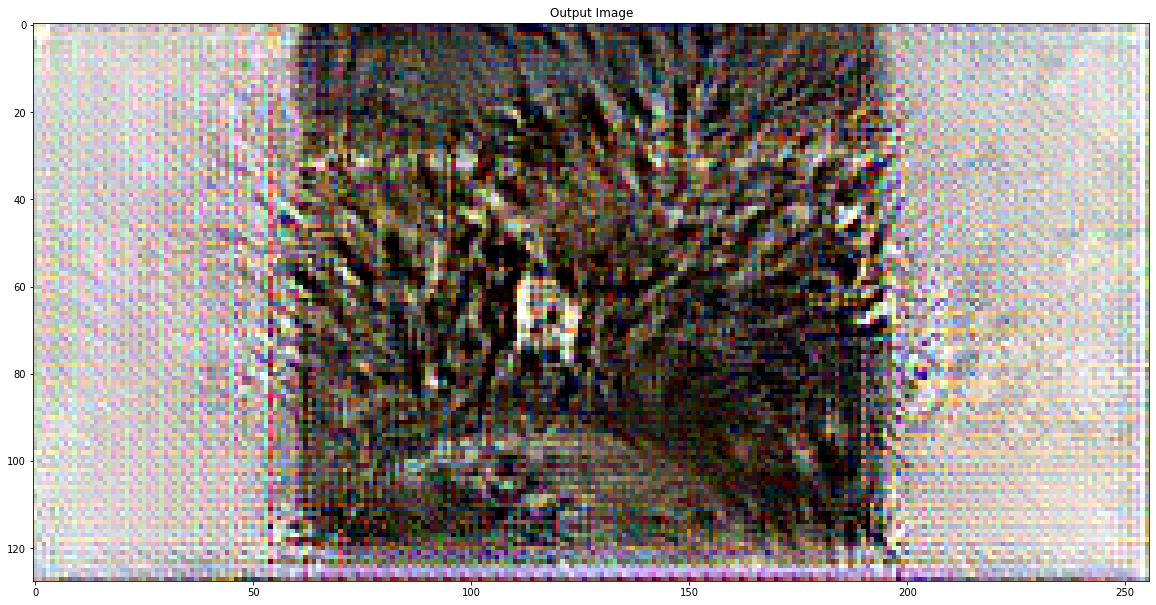

total time:  20.314172744750977  seconds


In [ ]:
start_time = time.time()
output, image, result = run_style_transfer('alexnet', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'mse', 'LBFGS', num_steps=200)
end_time = time.time()
plt.figure(figsize=(20, 20))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
print('total time: ', (end_time - start_time), ' seconds')

Building the style transfer model... (no amp)
model:  vgg , loss:  mse , optimizer:  Adam
Optimizing..


<ipython-input-178-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-178-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 928.440430 Content Loss: 16.894140

run [100]:
Style Loss : 304.876923 Content Loss: 15.939672

run [150]:
Style Loss : 180.814133 Content Loss: 15.446058

run [200]:
Style Loss : 125.386940 Content Loss: 15.023594

run [250]:
Style Loss : 94.191574 Content Loss: 14.623005

run [300]:
Style Loss : 74.433052 Content Loss: 14.228118



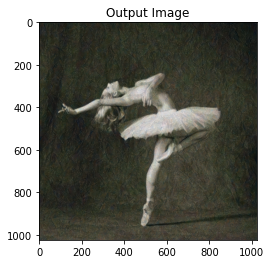

total time:  86.47742366790771  seconds


In [ ]:
start_time = time.time()
output, _, _ = run_style_transfer('vgg', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'mse', 'Adam')
end_time = time.time()
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
print('total time: ', (end_time - start_time), ' seconds')

In [ ]:
imshow(input_img)

In [ ]:
output, style_score, content_score = run_style_transfer('alexnet', cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 'mse', 'LBFGS')

plt.figure()
imshow(output, title='Output Image')
print(style_score, content_score)
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show() 

In [ ]:
output = run_style_transfer(resnet, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
run_models = ['vgg', 'alexnet']
run_loss_functions = ['mse', 'l1', 'smoothl1', 'huber']
run_optimizer = ['LBFGS', 'Adam', 'SGD']

In [ ]:
def run_model(model, loss_function, optimizer):
  start_time = time.time()
  if optimizer == 'LBFGS':
    output, style, content = run_style_transfer(model, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,
                            loss_function, optimizer)
  else:
    output, style, content = run_style_transfer_amp(model, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,
                            loss_function, optimizer, num_steps=500)
  end_time = time.time()

  plt.figure()
  imshow(output, title='Output Image')

  # sphinx_gallery_thumbnail_number = 4
  plt.ioff()
  plt.show()
  return style, content, end_time - start_time, output

def run():
  results = {}
  images = {}

  for model in run_models:
    model_results = {}
    results[model] = model_results

    model_images = {}
    images[model] = model_images

    for loss_function in run_loss_functions:
      loss_results = {}
      model_results[loss_function] = loss_results

      loss_images = {}
      model_images[loss_function] = loss_images

      for my_optimizer in run_optimizer:
        optimizer_results = {}
        loss_results[my_optimizer] = optimizer_results

        optimizer_images = {}
        loss_images[my_optimizer] = optimizer_images

        optimizer_results['style'], \
        optimizer_results['content'], \
        optimizer_results['time'], \
        optimizer_images['image'] \
        = run_model(model, loss_function, my_optimizer)
  
  return results, images


In [ ]:
from pprint import pprint
def print_results(results):
  pprint(results)

def print_images(images):
  for model in run_models:
    f, axarr = plt.subplots(len(run_loss_functions), len(run_optimizer), figsize=(15, 15))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    i = -1
    for loss_function in run_loss_functions:
      i = i + 1
      j = -1
      for my_optimizer in run_optimizer:
        j = j + 1

        image_tensor = images[model][loss_function][my_optimizer]['image']
        if torch.cuda.is_available():
          image_tensor = torch.Tensor.cpu(image_tensor)
        axarr[i, j].imshow(image_tensor.detach().numpy()[0].transpose(1, 2, 0))
        axarr[i, j].set_title('{} + {} + {}'.format(model, loss_function, my_optimizer))
    plt.show()

Building the style transfer model... (no amp)
model:  vgg , loss:  mse , optimizer:  LBFGS
Optimizing..


<ipython-input-178-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-178-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 8.385574 Content Loss: 5.347818

run [100]:
Style Loss : 1.657734 Content Loss: 3.793832

run [150]:
Style Loss : 0.736845 Content Loss: 2.964896

run [200]:
Style Loss : 0.463648 Content Loss: 2.579016

run [250]:
Style Loss : 0.345352 Content Loss: 2.375527

run [300]:
Style Loss : 0.271870 Content Loss: 2.273234



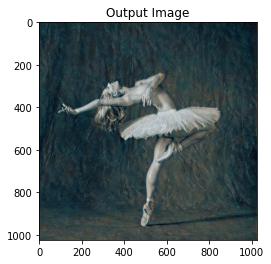

Building the style transfer model... (with AMP)
model:  vgg , loss:  mse , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 113936.289062 Content Loss: 32.644783

run [100]:
Style Loss : 113912.414062 Content Loss: 17.632387

run [150]:
Style Loss : 113842.726562 Content Loss: 8.317581

run [200]:
Style Loss : 113811.437500 Content Loss: 7.472591

run [250]:
Style Loss : 113803.914062 Content Loss: 7.302693

run [300]:
Style Loss : 113792.648438 Content Loss: 7.027025

run [350]:
Style Loss : 113781.984375 Content Loss: 6.646262

run [400]:
Style Loss : 113792.203125 Content Loss: 6.835787

run [450]:
Style Loss : 113772.906250 Content Loss: 6.524035

run [500]:
Style Loss : 113765.101562 Content Loss: 6.315263



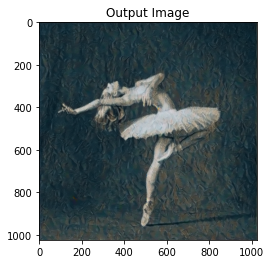

Building the style transfer model... (with AMP)
model:  vgg , loss:  mse , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 113889.398438 Content Loss: 35.241142

run [100]:
Style Loss : 113903.890625 Content Loss: 30.351761

run [150]:
Style Loss : 113885.523438 Content Loss: 26.543236

run [200]:
Style Loss : 113898.867188 Content Loss: 24.205204

run [250]:
Style Loss : 113899.187500 Content Loss: 22.113461

run [300]:
Style Loss : 113903.593750 Content Loss: 20.245045

run [350]:
Style Loss : 113894.929688 Content Loss: 18.404005

run [400]:
Style Loss : 113892.906250 Content Loss: 17.079002

run [450]:
Style Loss : 113887.585938 Content Loss: 15.745535

run [500]:
Style Loss : 113889.695312 Content Loss: 14.524746



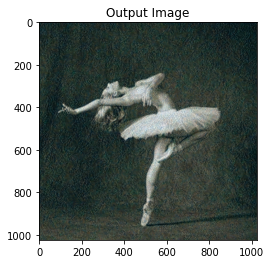

Building the style transfer model... (no amp)
model:  vgg , loss:  l1 , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 6848.876953 Content Loss: 1.825944

run [100]:
Style Loss : 2222.838135 Content Loss: 1.820890

run [150]:
Style Loss : 1458.785767 Content Loss: 1.822348

run [200]:
Style Loss : 1039.781128 Content Loss: 1.825532

run [250]:
Style Loss : 836.789062 Content Loss: 1.828367

run [300]:
Style Loss : 709.104797 Content Loss: 1.831000



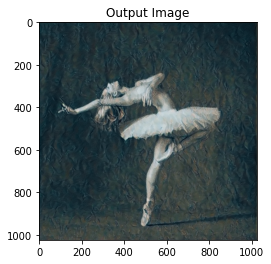

Building the style transfer model... (with AMP)
model:  vgg , loss:  l1 , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 4300657.500000 Content Loss: 3.694237

run [100]:
Style Loss : 4274383.000000 Content Loss: 2.158229

run [150]:
Style Loss : 4250728.500000 Content Loss: 2.001770

run [200]:
Style Loss : 4241774.500000 Content Loss: 1.963565

run [250]:
Style Loss : 4234021.000000 Content Loss: 1.943695

run [300]:
Style Loss : 4230136.500000 Content Loss: 1.935388

run [350]:
Style Loss : 4225941.500000 Content Loss: 1.931561

run [400]:
Style Loss : 4230081.500000 Content Loss: 1.930768

run [450]:
Style Loss : 4223902.500000 Content Loss: 1.913270

run [500]:
Style Loss : 4228673.000000 Content Loss: 1.921968



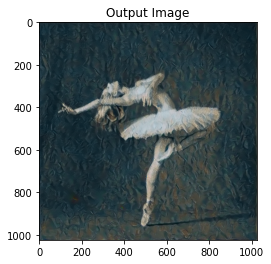

Building the style transfer model... (with AMP)
model:  vgg , loss:  l1 , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 4303103.500000 Content Loss: 4.760858

run [100]:
Style Loss : 4304524.000000 Content Loss: 5.003133

run [150]:
Style Loss : 4305037.500000 Content Loss: 4.787000

run [200]:
Style Loss : 4305226.500000 Content Loss: 4.838282

run [250]:
Style Loss : 4305526.000000 Content Loss: 4.709029

run [300]:
Style Loss : 4305438.500000 Content Loss: 4.710810

run [350]:
Style Loss : 4304646.500000 Content Loss: 4.695978

run [400]:
Style Loss : 4305456.500000 Content Loss: 4.834046

run [450]:
Style Loss : 4304926.000000 Content Loss: 4.591233

run [500]:
Style Loss : 4306286.000000 Content Loss: 4.649024



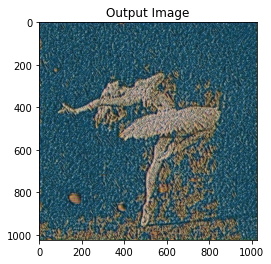

Building the style transfer model... (no amp)
model:  vgg , loss:  smoothl1 , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 3.740628 Content Loss: 1.345456

run [100]:
Style Loss : 0.733494 Content Loss: 1.185767

run [150]:
Style Loss : 0.315498 Content Loss: 0.999841

run [200]:
Style Loss : 0.187344 Content Loss: 0.881273

run [250]:
Style Loss : 0.133940 Content Loss: 0.805761

run [300]:
Style Loss : 0.099748 Content Loss: 0.758130



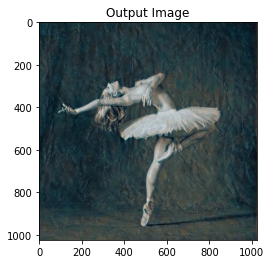

Building the style transfer model... (with AMP)
model:  vgg , loss:  smoothl1 , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 56967.988281 Content Loss: 3.963622

run [100]:
Style Loss : 56955.148438 Content Loss: 2.765953

run [150]:
Style Loss : 56919.710938 Content Loss: 1.716583

run [200]:
Style Loss : 56914.855469 Content Loss: 1.674512

run [250]:
Style Loss : 56907.929688 Content Loss: 1.583184

run [300]:
Style Loss : 56888.558594 Content Loss: 1.535191

run [350]:
Style Loss : 56882.984375 Content Loss: 1.517612

run [400]:
Style Loss : 56882.730469 Content Loss: 1.525407

run [450]:
Style Loss : 56886.871094 Content Loss: 1.520610

run [500]:
Style Loss : 56883.953125 Content Loss: 1.515604



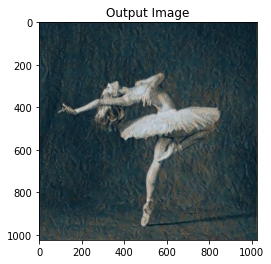

Building the style transfer model... (with AMP)
model:  vgg , loss:  smoothl1 , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 56941.644531 Content Loss: 4.302457

run [100]:
Style Loss : 56946.515625 Content Loss: 4.155292

run [150]:
Style Loss : 56948.441406 Content Loss: 3.980408

run [200]:
Style Loss : 56951.585938 Content Loss: 3.817312

run [250]:
Style Loss : 56949.558594 Content Loss: 3.643644

run [300]:
Style Loss : 56946.953125 Content Loss: 3.522117

run [350]:
Style Loss : 56947.574219 Content Loss: 3.407635

run [400]:
Style Loss : 56951.902344 Content Loss: 3.322451

run [450]:
Style Loss : 56946.582031 Content Loss: 3.227411

run [500]:
Style Loss : 56947.359375 Content Loss: 3.132117



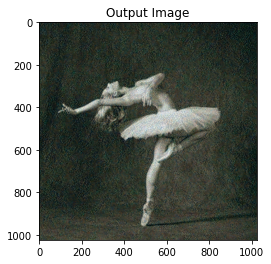

Building the style transfer model... (no amp)
model:  vgg , loss:  huber , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 3.789216 Content Loss: 1.348344

run [100]:
Style Loss : 0.713884 Content Loss: 1.180018

run [150]:
Style Loss : 0.309785 Content Loss: 0.996875

run [200]:
Style Loss : 0.187110 Content Loss: 0.879253

run [250]:
Style Loss : 0.133532 Content Loss: 0.804611

run [300]:
Style Loss : 0.100502 Content Loss: 0.759344



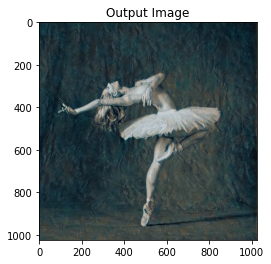

Building the style transfer model... (with AMP)
model:  vgg , loss:  huber , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 56967.988281 Content Loss: 3.963622

run [100]:
Style Loss : 56955.148438 Content Loss: 2.765953

run [150]:
Style Loss : 56919.710938 Content Loss: 1.716583

run [200]:
Style Loss : 56914.855469 Content Loss: 1.674512

run [250]:
Style Loss : 56907.929688 Content Loss: 1.583184

run [300]:
Style Loss : 56888.558594 Content Loss: 1.535191

run [350]:
Style Loss : 56882.984375 Content Loss: 1.517612

run [400]:
Style Loss : 56882.730469 Content Loss: 1.525407

run [450]:
Style Loss : 56886.871094 Content Loss: 1.520610

run [500]:
Style Loss : 56883.953125 Content Loss: 1.515604



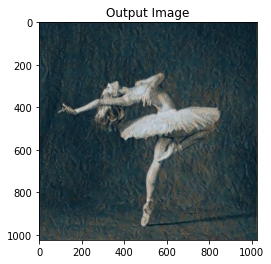

Building the style transfer model... (with AMP)
model:  vgg , loss:  huber , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 56941.644531 Content Loss: 4.302457

run [100]:
Style Loss : 56946.515625 Content Loss: 4.155292

run [150]:
Style Loss : 56948.441406 Content Loss: 3.980408

run [200]:
Style Loss : 56951.585938 Content Loss: 3.817312

run [250]:
Style Loss : 56949.558594 Content Loss: 3.643644

run [300]:
Style Loss : 56946.953125 Content Loss: 3.522117

run [350]:
Style Loss : 56947.574219 Content Loss: 3.407635

run [400]:
Style Loss : 56951.902344 Content Loss: 3.322451

run [450]:
Style Loss : 56946.582031 Content Loss: 3.227411

run [500]:
Style Loss : 56947.359375 Content Loss: 3.132117



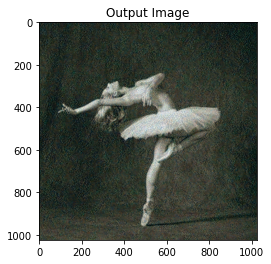

Building the style transfer model... (no amp)
model:  alexnet , loss:  mse , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 52.730843 Content Loss: 3.770039

run [100]:
Style Loss : 13.986135 Content Loss: 3.478560

run [150]:
Style Loss : 6.825093 Content Loss: 3.048272

run [200]:
Style Loss : 3.571490 Content Loss: 2.798909

run [250]:
Style Loss : 1.983698 Content Loss: 2.627885

run [300]:
Style Loss : 1.393070 Content Loss: 2.510867



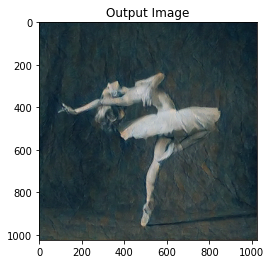

Building the style transfer model... (with AMP)
model:  alexnet , loss:  mse , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 553032.687500 Content Loss: 6.012297

run [100]:
Style Loss : 550054.562500 Content Loss: 5.794260

run [150]:
Style Loss : 550510.812500 Content Loss: 5.431280

run [200]:
Style Loss : 552148.125000 Content Loss: 5.601733

run [250]:
Style Loss : 550849.687500 Content Loss: 5.487499

run [300]:
Style Loss : 549172.125000 Content Loss: 5.551270

run [350]:
Style Loss : 547800.437500 Content Loss: 5.092813

run [400]:
Style Loss : 559746.812500 Content Loss: 6.337795

run [450]:
Style Loss : 551697.125000 Content Loss: 5.671664

run [500]:
Style Loss : 549043.750000 Content Loss: 5.541840



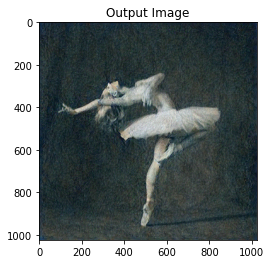

Building the style transfer model... (with AMP)
model:  alexnet , loss:  mse , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 700601.250000 Content Loss: 47.149059

run [100]:
Style Loss : 656698.750000 Content Loss: 14.171446

run [150]:
Style Loss : 696776.125000 Content Loss: 45.028652

run [200]:
Style Loss : 656166.750000 Content Loss: 16.117233

run [250]:
Style Loss : 697375.750000 Content Loss: 34.475712

run [300]:
Style Loss : 693593.062500 Content Loss: 27.814632

run [350]:
Style Loss : 669472.687500 Content Loss: 12.473925

run [400]:
Style Loss : 646780.937500 Content Loss: 10.945354

run [450]:
Style Loss : 627713.937500 Content Loss: 9.216254

run [500]:
Style Loss : 697528.312500 Content Loss: 16.946997



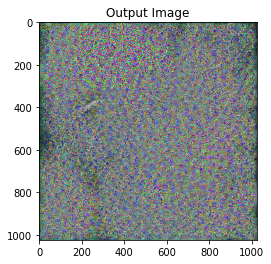

Building the style transfer model... (no amp)
model:  alexnet , loss:  l1 , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 16138.948242 Content Loss: 1.609716

run [100]:
Style Loss : 9190.967773 Content Loss: 1.605871

run [150]:
Style Loss : 6501.403320 Content Loss: 1.603213

run [200]:
Style Loss : 5015.119141 Content Loss: 1.614198

run [250]:
Style Loss : 4090.461426 Content Loss: 1.626514

run [300]:
Style Loss : 3440.962158 Content Loss: 1.638535



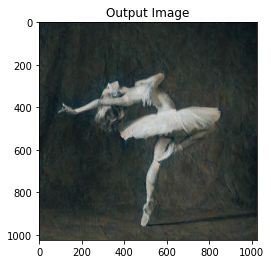

Building the style transfer model... (with AMP)
model:  alexnet , loss:  l1 , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 6737205.500000 Content Loss: 1.746439

run [100]:
Style Loss : 6167035.500000 Content Loss: 1.769565

run [150]:
Style Loss : 6251349.500000 Content Loss: 1.725778

run [200]:
Style Loss : 6120389.000000 Content Loss: 1.793554

run [250]:
Style Loss : 5990806.000000 Content Loss: 1.778350

run [300]:
Style Loss : 6013380.500000 Content Loss: 1.771253

run [350]:
Style Loss : 5927235.500000 Content Loss: 1.780913

run [400]:
Style Loss : 5908873.500000 Content Loss: 1.780198

run [450]:
Style Loss : 5910411.500000 Content Loss: 1.776134

run [500]:
Style Loss : 5848470.500000 Content Loss: 1.802252



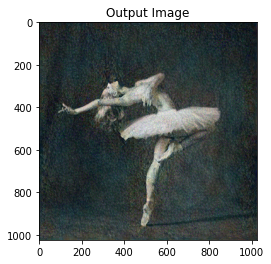

Building the style transfer model... (with AMP)
model:  alexnet , loss:  l1 , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 10899554.000000 Content Loss: 20.968904

run [100]:
Style Loss : 10883237.000000 Content Loss: 17.859940

run [150]:
Style Loss : 10682482.000000 Content Loss: 27.134251

run [200]:
Style Loss : 10951739.000000 Content Loss: 20.332550

run [250]:
Style Loss : 10887415.000000 Content Loss: 19.025331

run [300]:
Style Loss : 10843740.000000 Content Loss: 19.263714

run [350]:
Style Loss : 10944470.000000 Content Loss: 19.068943

run [400]:
Style Loss : 11028984.000000 Content Loss: 15.503322

run [450]:
Style Loss : 10703120.000000 Content Loss: 24.167131

run [500]:
Style Loss : 10933884.000000 Content Loss: 22.214037



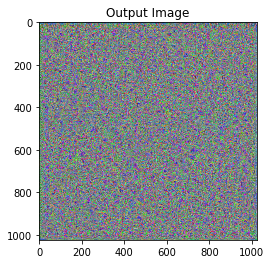

Building the style transfer model... (no amp)
model:  alexnet , loss:  smoothl1 , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 24.033297 Content Loss: 1.066872

run [100]:
Style Loss : 6.523928 Content Loss: 1.042776

run [150]:
Style Loss : 3.245090 Content Loss: 0.990506

run [200]:
Style Loss : 1.710363 Content Loss: 0.939004

run [250]:
Style Loss : 0.902183 Content Loss: 0.899292

run [300]:
Style Loss : 0.599051 Content Loss: 0.862831



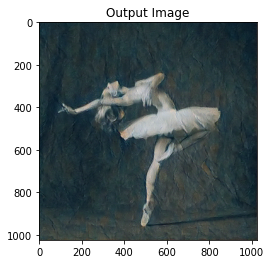

Building the style transfer model... (with AMP)
model:  alexnet , loss:  smoothl1 , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 275443.718750 Content Loss: 1.315990

run [100]:
Style Loss : 274293.312500 Content Loss: 1.283166

run [150]:
Style Loss : 274129.593750 Content Loss: 1.257660

run [200]:
Style Loss : 274593.156250 Content Loss: 1.261382

run [250]:
Style Loss : 274740.500000 Content Loss: 1.295900

run [300]:
Style Loss : 273746.718750 Content Loss: 1.245580

run [350]:
Style Loss : 273185.437500 Content Loss: 1.245735

run [400]:
Style Loss : 272590.906250 Content Loss: 1.232177

run [450]:
Style Loss : 274249.281250 Content Loss: 1.286864

run [500]:
Style Loss : 273900.343750 Content Loss: 1.290394



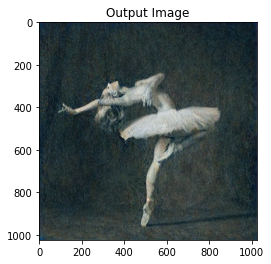

Building the style transfer model... (with AMP)
model:  alexnet , loss:  smoothl1 , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 319334.656250 Content Loss: 1.930702

run [100]:
Style Loss : 320701.218750 Content Loss: 1.860761

run [150]:
Style Loss : 299251.093750 Content Loss: 1.931276

run [200]:
Style Loss : 297508.500000 Content Loss: 1.868701

run [250]:
Style Loss : 298448.250000 Content Loss: 1.892665

run [300]:
Style Loss : 296207.500000 Content Loss: 1.770124

run [350]:
Style Loss : 299613.000000 Content Loss: 1.903670

run [400]:
Style Loss : 311757.375000 Content Loss: 1.603122

run [450]:
Style Loss : 298008.218750 Content Loss: 1.933537

run [500]:
Style Loss : 297422.437500 Content Loss: 1.902884



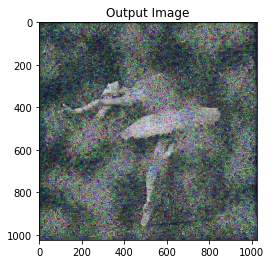

Building the style transfer model... (no amp)
model:  alexnet , loss:  huber , optimizer:  LBFGS
Optimizing..
run [50]:
Style Loss : 23.965582 Content Loss: 1.063607

run [100]:
Style Loss : 6.553878 Content Loss: 1.045628

run [150]:
Style Loss : 3.241059 Content Loss: 0.988964

run [200]:
Style Loss : 1.724225 Content Loss: 0.940963

run [250]:
Style Loss : 0.882157 Content Loss: 0.897310

run [300]:
Style Loss : 0.590093 Content Loss: 0.859865



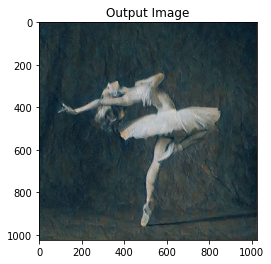

Building the style transfer model... (with AMP)
model:  alexnet , loss:  huber , optimizer:  Adam
Optimizing..
run [50]:
Style Loss : 275443.718750 Content Loss: 1.315990

run [100]:
Style Loss : 274293.312500 Content Loss: 1.283166

run [150]:
Style Loss : 274129.593750 Content Loss: 1.257660

run [200]:
Style Loss : 274593.156250 Content Loss: 1.261382

run [250]:
Style Loss : 274740.500000 Content Loss: 1.295900

run [300]:
Style Loss : 273746.718750 Content Loss: 1.245580

run [350]:
Style Loss : 273185.437500 Content Loss: 1.245735

run [400]:
Style Loss : 272590.906250 Content Loss: 1.232177

run [450]:
Style Loss : 274249.281250 Content Loss: 1.286864

run [500]:
Style Loss : 273900.343750 Content Loss: 1.290394



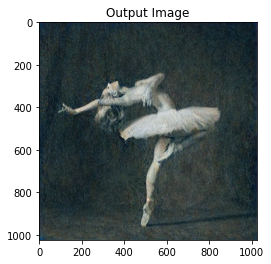

Building the style transfer model... (with AMP)
model:  alexnet , loss:  huber , optimizer:  SGD
Optimizing..
run [50]:
Style Loss : 319334.656250 Content Loss: 1.930702

run [100]:
Style Loss : 320701.218750 Content Loss: 1.860761

run [150]:
Style Loss : 299251.093750 Content Loss: 1.931276

run [200]:
Style Loss : 297508.500000 Content Loss: 1.868701

run [250]:
Style Loss : 298448.250000 Content Loss: 1.892665

run [300]:
Style Loss : 296207.500000 Content Loss: 1.770124

run [350]:
Style Loss : 299613.000000 Content Loss: 1.903670

run [400]:
Style Loss : 311757.375000 Content Loss: 1.603122

run [450]:
Style Loss : 298008.218750 Content Loss: 1.933537

run [500]:
Style Loss : 297422.437500 Content Loss: 1.902884



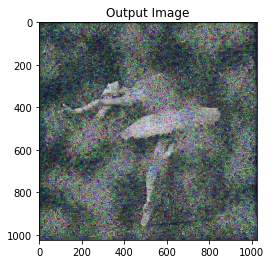

In [ ]:
results, images = run()

{'alexnet': {'huber': {'Adam': {'content': 1.2756989002227783,
                                'style': 273535.71875,
                                'time': 6.076727628707886},
                       'LBFGS': {'content': 0.8469727635383606,
                                 'style': 0.5244361162185669,
                                 'time': 21.88545250892639},
                       'SGD': {'content': 1.815782904624939,
                               'style': 296322.84375,
                               'time': 5.7102532386779785}},
             'l1': {'Adam': {'content': 1.838521122932434,
                             'style': 6058592.5,
                             'time': 6.12050461769104},
                    'LBFGS': {'content': 1.6416826248168945,
                              'style': 3254.2880859375,
                              'time': 21.90787649154663},
                    'SGD': {'content': 17.281633377075195,
                            'style': 11044601.0,
            

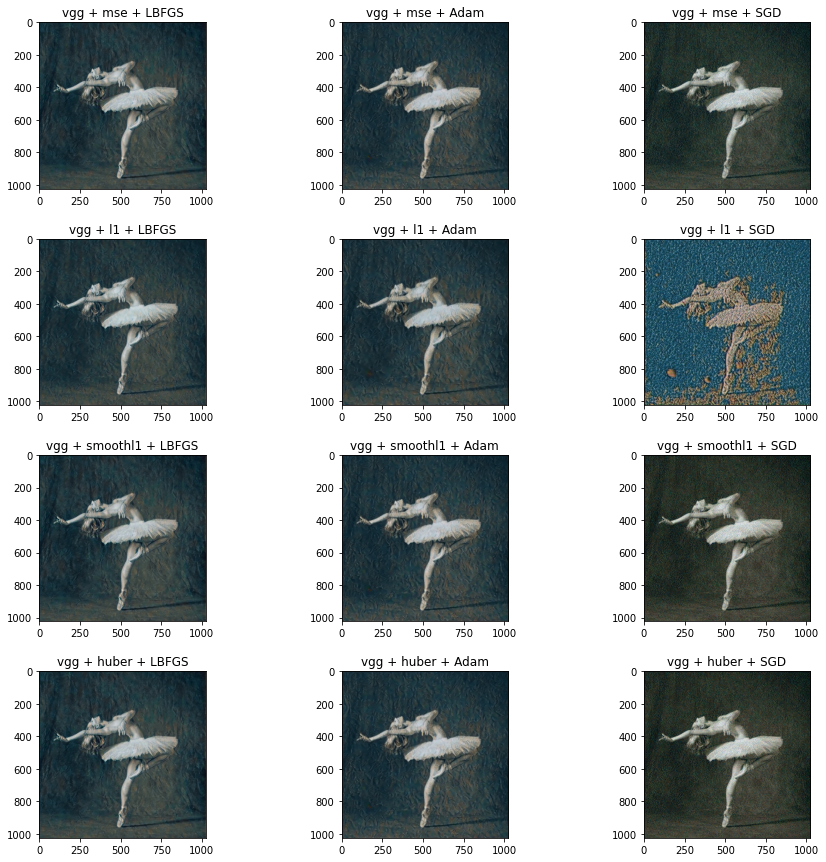

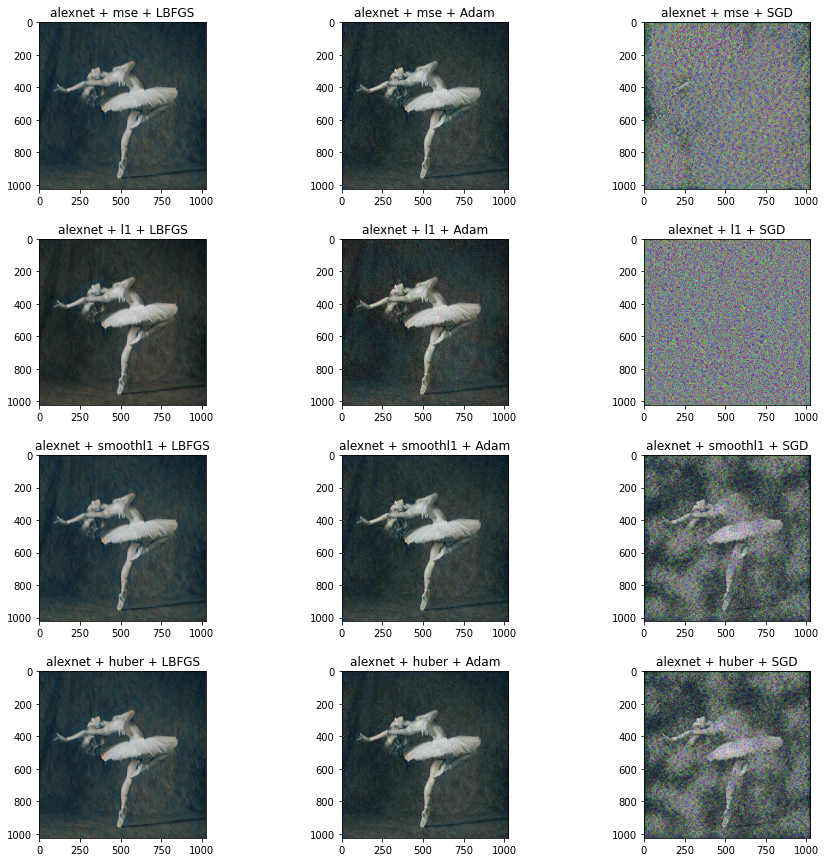

In [ ]:
print_results(results)
print_images(images)

In [ ]:
run()

In [ ]:
print_results(results)
print_images(images)